Convolutional Neural Networks (CNNs) are powerful tools for computer vision tasks. In this notebook, I build and train a simple CNN for the purpose of recognising hand-written digits. The data is a collection of 70,000 28x28 pixel images of hand-written digits 0-9, therefore this is a 10-class classification problem. 

More information about the dataset can be found [here](https://en.wikipedia.org/wiki/MNIST_database)

## This notebook contains the following content:
* [1. Importing & Investigating the data](#first-bullet)
* [2. Building the Neural Network with Keras](#second-bullet)
* [3. Sources of Error](#third-bullet)
* [4. Conclusions](#fourth-bullet)

## Importing & Investigating the data <a class="anchor" id="first-bullet"></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_mldata

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
mnist = fetch_mldata('MNIST original')
pixel_data = mnist.data

In [3]:
pixel_data.shape

(70000, 784)

We can see that the 70,000 examples are currently in flat vectors of 784 pixels, we will need to convert these to 28x28 to process with convolutional filters.

In [4]:
mnist.target.shape

(70000,)

Text(0.5,1,'Frequency of each digit in the entire MNIST dataset')

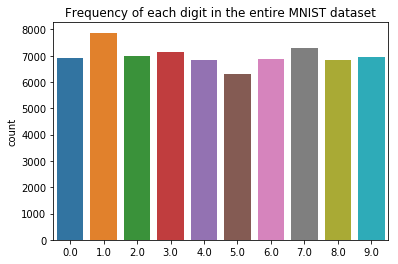

In [5]:
target = mnist.target
sns.countplot(target)
plt.title('Frequency of each digit in the entire MNIST dataset')

The target values are currently a single floating point number from 0.0 to 9.0 per example. Generally for multi-class classification with neural networks we need this in one-hot format so we will need to convert the data later.

Looking at the count of each digit, we can see that the classes are fairly even and therefore the majority class classifier will perform very poorly (~10%). We should be able to beat this very handily with our CNN.

Let's take a look at the images by reshaping them:

In [6]:
#reshape the pixel data to have shape (70000, 28, 28, 1)
pixel_data = pixel_data.reshape((pixel_data.shape[0],28,28,1))
pixel_data.shape

(70000, 28, 28, 1)

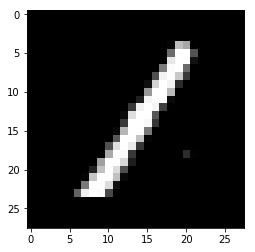

In [7]:
#take a look at the image at index 10,000
plt.imshow(pixel_data[10000,:,:,0], cmap='gray')

In [8]:
#and print the associated target
print(str(target[10000]))

1.0


Our images are now in the correct format and the label is correct for the image above so we can now split our data into training and testing sets.

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
#use 80% of the data in the training set and keep 20% back for testing purposes
X_train, X_test, Y_train, Y_test = train_test_split(pixel_data, target, test_size=0.2, random_state=1)

In [11]:
#check the new shape of our training data
X_train.shape

(56000, 28, 28, 1)

## 2. Building the Neural Network with Keras <a class="anchor" id="second-bullet"></a>

### Convolutions
A Convolution is the process of passing a filter over consecutive sections of an image to produce an output.

<img src='https://s3-eu-west-1.amazonaws.com/com.cambridgespark.content/tutorials/convolutional-neural-networks-with-keras/figures/convolve.png' style="max-width:80%;">
Credit to https://cambridgespark.com/ for the image

The original image is represented on the left, the filter is the blue matrix and the output of the convolution is on the right. The green cell in the output matrix comes from the sum of the element wise products of the filter with the red section of the input matrix. The size of the output matrix depends on the size of the input, the size of the filter, the **stride** (which is essentially how far the filter moves across the input matrix in each step) and the **padding** (which is empty cells added around the input matrix to get specific shape outputs). The size of the output is defined by the following formula:

\begin{equation*}
W_{out} = \frac{W_{in} - F + 2P}{S} + 1
\end{equation*}

Where $F$ is the size of the filter e.g. F = 3 for a 3x3 filter, $P$ is the number of padding pixels added to each dimension of the input and $S$ is the stride. This formula works for both height and width.

If we didn't use any padding, the output would be smaller than the input. For this reason we use what is called 'same' padding, where we add enough padding to keep the input and output dimensions equal.

### Pooling
Pooling layers are used to reduce the dimensions of the image between convolutions. This is needed because if the images stayed the same size throughout the network the number of learnable paramaters would get very large. 

<img src='https://cdn-images-1.medium.com/max/800/1*C0EwU0aknuliOsGktK6U0g.png' style="max-width:80%;">
Credit to https://medium.com/data-science-group-iitr for the image

Pooling works by applying an aggregating function to a section of the input. In the example above, a 2x2 filter is passed over the input with a stride of 2. This means that none of the areas overlap and the output dimensions are exactly half of the input dimensions. 

The 2 most common aggregating functions applied by Pooling layers are **max** and **average**. Max pooling simply takes the maximum value from each 2x2 section of the input and puts it in the corresponding cell of the output, whilst Average pooling takes the average value of the 2x2 section instead. 

### Fully-connected layers
A fully-connected/dense layer is simply a layer in which all of the input values are connected to each of the hidden units in the layer. This is a standard Neural Network layer.

### Dropout layers
A dropout layer connects 2 layers and has a defined dropout rate. During training, each of the connections has a chance of being ignored (weight on the connection set to zero) equal to the dropout rate. This means that the network cannot heavily rely on a particular connection to produce it's outputs. The weights are more evenly shared across the network and this reduces overfitting.

### Softmax layers
A softmax layer is used for classification problems. It takes the scores computed by the rest of the network and normalizes them to probabilities such that the sum of the probabilities for each class for a particular example are equal to 1. For a softmax layer with K hidden units, each hidden unit has a score $z_{k}$ and the activation (read: probability) output by each unit is: 

\begin{equation*}
\frac{e^{z_{k}}}{\sum_{k=1}^{K} e^{z_{k}}}
\end{equation*}

### Architecture of our CNN:
* Convolutional layer, 32 5x5 filters and 'same' padding. For each 28x28x1 image input we get a 28x28x32 tensor. ReLU activation.
* Max pooling layer, 2x2 filter, results in a 14x14x32 tensor for each image.
* Convolutional layer, 64 5x5(x32) filters and 'same' padding. For each 14x14x32 input we get a 14x14x64 tensor. ReLU activation.
* Max pooling layer, 2x2 filter, results in a 7x7x64 tensor for each image.
* Flatten the output into a single dimension of 7x7x64 = 3136.
* Dense layer with 1024 hidden units, output has length 1024. ReLU activation.
* Dropout layer to avoid overfitting, rate=0.4 i.e. for each training batch, every hidden unit output has a 40% chance of being dropped.
* Dense layer with 10 hidden units and Softmax activation that converts the 10 outputs into probabilities for each class.

In [12]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.models import Model
from keras.optimizers import SGD

Using TensorFlow backend.


In [13]:
#input layer
inputs = Input(shape=(28,28,1))

#first conv and pool
x = Conv2D(32, kernel_size=5, padding='same', activation='relu')(inputs)
x = MaxPooling2D(pool_size=(2,2), strides=2 )(x)

#second conv and pool
x = Conv2D(64, kernel_size=5, padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2,2), strides=2)(x)

#flatten, dense and dropout layers
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.4)(x)

#softmax layers
predictions = Dense(10, activation = 'softmax' )(x)

#define and compile model with Stochastic Gradient Descent optimizer
model = Model(inputs=inputs, outputs=predictions)

opt = SGD(lr=0.001)

model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

The loss function we have used is categorical cross-entropy. For a single training example with one-hot label vector $y$ and predicted probability vector for each class $p$ the cost defined by the following equation:

\begin{equation*}
-\sum_{c=1}^{M} y_{o, c} \log{p_{o, c}}
\end{equation*}

Where M is the number of classes, and $p_{o, c}$ is the probability predicted for observation $o$ for class $c$.

Let's feed an input image into the network and check the shape of the output so that we can convert our labels to the correct format.

In [15]:
print(model.predict(X_train[0:1,...]))
print(model.predict(X_train[0:1,...]).shape)

[[  1.55023879e-26   4.98738154e-05   7.22989171e-07   9.74239023e-11
    1.66462082e-29   9.99949455e-01   3.94156964e-19   2.06563839e-24
    3.44584417e-10   1.93107588e-13]]
(1, 10)


Output is a one-hot vector with length 10, we need to convert our Y_train and Y_test vectors to be one-hot.

In [16]:
Y_train = np.eye(10)[Y_train.astype(int)]
Y_test = np.eye(10)[Y_test.astype(int)]
Y_train.shape

(56000, 10)

In [17]:
hist = model.fit(x=X_train, y=Y_train, batch_size=64, epochs=15, validation_split=0.1)

Train on 50400 samples, validate on 5600 samples
Epoch 1/15
50400/50400 [==============================] - 16s 321us/step - loss: 1.1743 - acc: 0.8545 - val_loss: 0.1154 - val_acc: 0.9637
Epoch 2/15
50400/50400 [==============================] - 16s 314us/step - loss: 0.1564 - acc: 0.9529 - val_loss: 0.0883 - val_acc: 0.9734
Epoch 3/15
50400/50400 [==============================] - 16s 310us/step - loss: 0.1121 - acc: 0.9645 - val_loss: 0.0710 - val_acc: 0.9788
Epoch 4/15
50400/50400 [==============================] - 16s 316us/step - loss: 0.0916 - acc: 0.9718 - val_loss: 0.0636 - val_acc: 0.9793
Epoch 5/15
50400/50400 [==============================] - 16s 311us/step - loss: 0.0771 - acc: 0.9762 - val_loss: 0.0596 - val_acc: 0.9804
Epoch 6/15
50400/50400 [==============================] - 15s 306us/step - loss: 0.0682 - acc: 0.9783 - val_loss: 0.0517 - val_acc: 0.9834
Epoch 7/15
50400/50400 [==============================] - 16s 308us/step - loss: 0.0605 - acc: 0.9808 - val_loss: 0.0

In [18]:
model.evaluate(x=X_test, y=Y_test)

14000/14000 [==============================] - 3s 212us/step


[0.039269620979304559, 0.98792857142857138]

We are accurately classifying 98.8% of of the test set which is extremely good. Let's take a look at the training history.

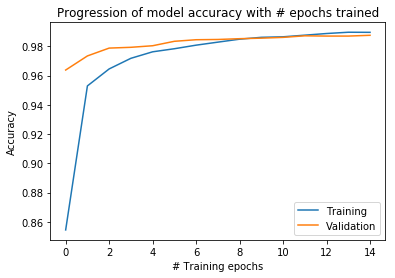

In [19]:
plt.plot(hist.history['acc'], label='Training')
plt.plot(hist.history['val_acc'], label='Validation')
plt.xlabel('# Training epochs')
plt.ylabel('Accuracy')
plt.title('Progression of model accuracy with # epochs trained')
plt.legend()

We can see that we are not overfitting to the training set because the validation set accuracy is still increasing slightly. If we were overfitting then we would expect the validation accuracy to begin to drop. If this were a production network we would continue training until the validation accuracy reaches a maximum, however for the purposes of this notebook we will stop here and look at the sources of error in the model.

## 3. Sources of Error <a class="anchor" id="third-bullet"></a>

Let's take a look at the confusion matrix for this models predictions.

In [20]:
prediction_probs = model.predict(X_test)

In [21]:
predictions = np.where(prediction_probs > 0.5, 1, 0)

In [22]:
predictions[0]

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0])

In [23]:
from sklearn.metrics import confusion_matrix

In [24]:
confusion_matrix(Y_test.argmax(axis=1), predictions.argmax(axis=1))

array([[1378,    0,    1,    1,    0,    0,    1,    0,    4,    0],
       [   0, 1615,    6,    2,    0,    0,    1,    4,    1,    0],
       [   5,    3, 1427,    1,    0,    0,    1,    1,    2,    1],
       [   5,    0,    2, 1407,    0,    7,    0,    1,    6,    3],
       [   3,    4,    1,    0, 1313,    0,    0,    0,    1,    9],
       [   4,    0,    0,    4,    0, 1219,    1,    0,    1,    0],
       [   5,    1,    0,    1,    2,    4, 1382,    0,    2,    0],
       [   7,    2,    5,    1,    1,    0,    0, 1449,    2,    8],
       [   6,    2,    3,    3,    0,    2,    4,    1, 1319,    3],
       [   6,    1,    0,    1,   11,    3,    0,    5,    2, 1310]], dtype=int64)

In a confusion matrix, the leading diagonal represents the correctly classified examples. The rows are the true labels and the columns are the predicted labels. For example, the cell [3,3] would be the value corresponding to examples of digit 3 that were correctly classified as digit 3.

The off-diagonal cells represent incorrect classifications, and by looking at the values we can see if there are any classes that are consistently mixed up by the model.

Cell [9,4] has the highest value of the off-diagonal cells. Cell [9,4] represents examples of digit 9 that were predicted to be digit 4. We can see that both digits consist of a closed loop at the top with a tail at the bottom, so it is again easy to see how they could be mixed up. Let's take a look at the misclassified examples of these 2 cells.

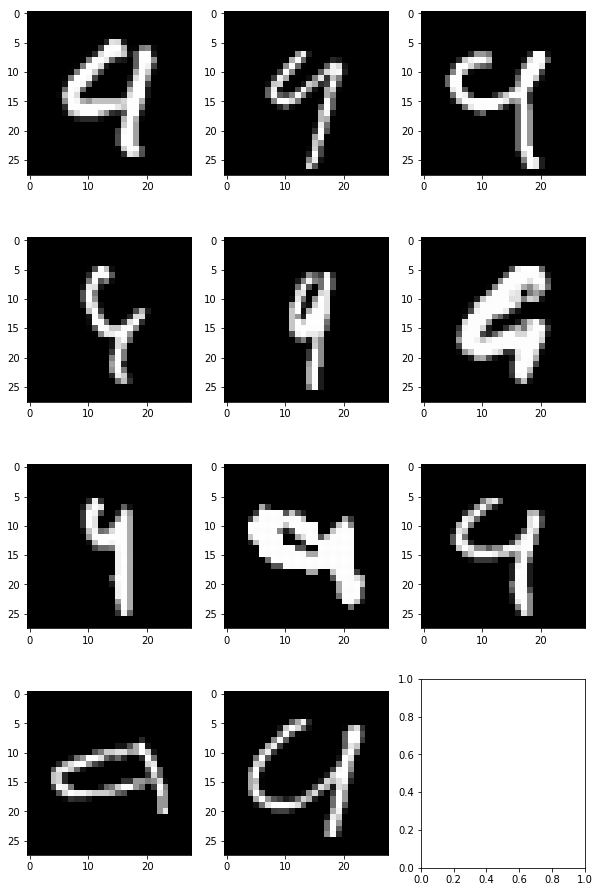

In [26]:
nine_as_four = X_test[(Y_test.argmax(axis=1) == 9) & (predictions.argmax(axis=1) == 4)]
fig, axes = plt.subplots(len(nine_as_four)//3 + 1, 3, figsize=(10, 16))

for i in range(len(nine_as_four)):
    axes.ravel()[i].imshow(nine_as_four[i, :, :, 0], cmap='gray')

Personally, I would have guessed that some of these were actually 4's if I were given the task of classifying them. For a 9, we expect a closed upper loop which is not the case for many of these examples. Let's take a quick look at the probabilities predicted for the misclassified 9's.

In [27]:
print('Probability of a 4 . . . . . . . Probability of a 9')
for array in prediction_probs[(Y_test.argmax(axis=1) == 9) & (predictions.argmax(axis=1) == 4)]:
    print('. . ' , array[4],'. . . . . . . . . . . . ', array[9])

Probability of a 4 . . . . . . . Probability of a 9
. .  0.845356 . . . . . . . . . . . .  0.15464
. .  0.772014 . . . . . . . . . . . .  0.227547
. .  0.929853 . . . . . . . . . . . .  0.0700139
. .  0.643329 . . . . . . . . . . . .  0.301386
. .  0.765154 . . . . . . . . . . . .  0.234022
. .  0.886618 . . . . . . . . . . . .  0.107672
. .  0.721242 . . . . . . . . . . . .  0.277797
. .  0.918991 . . . . . . . . . . . .  0.0805907
. .  0.771231 . . . . . . . . . . . .  0.228758
. .  0.544733 . . . . . . . . . . . .  0.0846578
. .  0.71659 . . . . . . . . . . . .  0.282303


Because these were all predicted to be 4's we know that the left hand column will always be over 0.5. We can see that there were 2 instances where the probability of a 4 was above 0.9 whilst the rest had some reasonable doubt. Particularly the second to last instance which was only 54% sure that the digit was a 4.

## 4. Conclusions <a class="anchor" id="fourth-bullet"></a>
* We have seen that a simple Convolutional Neural Network with 2 convolutional layers and 1 fully-connected layer was able to recognise hand-written digits with an accuracy of 98.7%. 
* We have also seen that a lot of the misclassified examples in the test set were poorly written/ambiguous, so it is unlikely that we would get much better performance by tweaking the network architecture.
* Because all of the classes are reasonably evenly represented, a random choice model would only score roughly 10% accuracy (because there are 10 classes). We have improved upon this significantly.